In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Theoretical Part
## 1) Hypothesis Testing – The problem of multiple comparisons [5 points]
Experimentation in AI often happens like this: 
Modify/Build an algorithm
Compare the algorithm to a baseline by running a hypothesis test.
If not significant, go back to step A
If significant, start writing a paper. 
How many hypothesis tests, m, does it take to get to (with Type I error for each test = α):

a) P(mth experiment gives significant result | m experiments lacking power to reject H0)?

b) P(at least one significant result | m experiments lacking power to reject H0)?

a) If all m experiments lack the power reject the null hypothesis, we still assume that the results come from the probability distribution of H0. The probability of a significant result is given by the probability mass to the right of the critical value, corrected as the family-wise error rate.
 
P(mth experiment gives significant result | m experiments lacking power to reject H0) = $$1 - (1-\alpha)^m$$

b) The probability of finding at least one significant result is the complement of finding no significant results.

P(at least one significant result | m experiments lacking power to reject H0) =

$$1 - (1-\alpha)^m$$

## 2) Bias and unfairness in Interleaving experiments [10 points]

Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?


# Practical part
## Step 1: Simulate Rankings of Relevance for E and P (5 points)

In [2]:
from itertools import product
 
def generate_ranking_pairs(grades, rank_len):
    """ Generates all possible ranking pairs, excluding pairs of 
        equal rankings

    Args:
        grades (list): Possible grades in ranking.
        rank_len (int): Length of ranking pairs.

    Returns:
        generator: All possible ranking pairs.
    """
    
    # generate all possible rankings
    rankings = product(grades, repeat=rank_len)
    # generate all possible pairs of rankings
    pairs = product(rankings, repeat=2)    
    # exclude pairs of equal rankings
    pairs = filter(lambda pair: pair[0] != pair[1], pairs)
    
    return pairs

grades = ['HR', 'R', 'N']
rank_len = 5

ranking_pairs = list(generate_ranking_pairs(grades, rank_len))
print('Number of possible ranking pairs: ', len(ranking_pairs))

Number of possible ranking pairs:  58806


## Step 2: Implement Evaluation Measures (10 points)

In [3]:
def average_precision(rankings):    
    """Calculates Average Precision (AP) = Average of precisions at relevant documents

    Args:
        rankings (list): ranked result of query.

    Returns:
        float: The average precision of rankings.
    """
    relevant = 0
    numerator = 0
    for rank, rel in enumerate(rankings):
        rank += 1
        if rel == 'R' or rel == 'HR':
            relevant += 1
            numerator += relevant/rank
    return numerator/len(rankings)

The scores for relevance that are used are 0, 1 and 5 for N, R and HR respectively (equal to example in slides).

The nDCG@k measures requires the total number of relevant and highly relevant documents in the entire collection. Since
for this dummy example there does not really exist a corpus, another approach is required:

def nDCGk is feeded a ranking of length 5 (one of the permutations created in Step 1). This list of five is treated
as the corpus. The list consisting of the first k elements is seen as the result of a query q, and the DCGk of this
list is calculated by def DCGk. To find the perfect ranking (for normalization), the corpus list is sorted (descending)
and the DCGk of the top k elements of the resulting list is calculated. The result is then used for normalization 
in def nDCGk.

In [4]:
import math

def DCGk(rankings):
    """Calculates Discounted Cumulative Gain (DCG)

    Args:
        rankings (list): ranked result of query.

    Returns:
        float: The discounted cumulative gain.
    """
    discounted_gain = 0
    for rank, rel in enumerate(rankings):
        rank += 1
        gain = (2**rel)-1
        discount = 1/math.log(rank+1,2)    
        discounted_gain += gain*discount        
    return discounted_gain

def nDCGk(rankings, k=3):
    """Calculates Normalized Discounted Cumulative Gain at rank k (nDCG@k)

    Args:
        rankings (list): ranked result of query. (treated as corpus)
        k (int): rank k. Value of 3 is used if no argument is given.

    Returns:
        float: The normalized discounted gain at rank k.
    """
    # translate relevance to corresponding score for calculations
    rankings = [5 if x is 'HR' else 1 if x is 'R' else 0 for x in rankings]
    # calculate discounted gain for top k
    DCG = DCGk(rankings[:k])
    # sort all relevant documents (descending) in the corpus by their 
    # relative relevance to find best possible DCG result (perfect ranking)
    perfect_DCG = DCGk(sorted(rankings, reverse=True)[:k])
    # normalize discounted_gain by this result
    if perfect_DCG == 0:
        return 0
    return DCG/perfect_DCG

#nDCGk(ranking_pairs[0][0])

In [5]:
def ERR(rankings, k=5):
    """Computes the Expected Reciprocal Rank (ERR) metric in linear time. Based on paper by Chapelle et al.

    Args:
        rankings (list): ranked result of query.
        k (int): rank k. Value of 5 is used if no argument is given.

    Returns:
        float: the Expected Reciprocal Rank (ERR).
    """
    # translate relevance to corresponding score for calculations
    rankings = [5 if x is 'HR' else 1 if x is 'R' else 0 for x in rankings]
    p = 1.0
    err = 0.0
    for rank, rel in enumerate(rankings[:k]):
        rank += 1
        R = ((2**rel)-1) / (2**max(rankings))
        err += p*(R/rank)
        p *= 1-R
    return err

ERR(ranking_pairs[100][1])

0.5078201293945312

## Step 3: Calculate the delta measure (0 points)

In [6]:
def delta_measure(P, E, measure):
    """Computes the delta of P and E for average precision, nDCG@k or ERR.

    Args:
        P (list): ranked result of production algorithm.
        E (list): ranked result of experimental algorithm.
        measure (string): measure to be calculated (average precision, nDCGk, ERR)

    Returns:
        float: delta of E and P. If < 0, E does not outperform P.
    """
    if measure == 'average precision':
        P_measure = average_precision(P)
        E_measure = average_precision(E)
    elif measure == 'nDCGk':
        P_measure = nDCGk(P)
        E_measure = nDCGk(E)
    elif measure == 'ERR':
        P_measure = ERR(P)
        E_measure = ERR(E)
    
    return E_measure - P_measure

## Step 4: Implement Interleaving (15 points)

In [7]:
from random import randint

def interleave(ranking_A, ranking_B):
    """
    Interleaves rankings from two different ranking algorithms into 
    one ranking based on Team Draft Interleaving. Both rankings are
    assumed to have equal length.
    
    Args:
        ranking_A (list): Ranking of algorithm A.
        ranking_B (list): Ranking of algorithm B.
        
    Returns:
        (Dict): Dict containing two lists: the interleaved ranking and the origins.
    """
    ranking_I = []
    origins = []
    i = 0
    while len(ranking_I) < len(ranking_A):
        # A wins
        if randint(0,1) == 0:
            origins += [0,1]
            ranking_I.append(ranking_A[i])
            ranking_I.append(ranking_B[i])
        # B wins
        else:
            origins += [1,0]
            ranking_I.append(ranking_B[i])
            ranking_I.append(ranking_A[i])
        i += 1
    if len(ranking_I) > len(ranking_A):
        ranking_I = ranking_I[0:-1]
        origins = origins[0:-1]
    return {'ranking': ranking_I, 'origins': origins}

In [8]:
ranking_A = ['N','N','R','HR','N']
ranking_B = ['R','HR','N','N','R']
interleaved_ranking = interleave(ranking_A, ranking_B)
print(ranking_A, ranking_B)
print(interleaved_ranking['ranking'])

['N', 'N', 'R', 'HR', 'N'] ['R', 'HR', 'N', 'N', 'R']
['R', 'N', 'N', 'HR', 'R']


## Step 5: Implement User Clicks Simulation (15 points)
### Random Click Model

In [9]:
from random import uniform

class RandomClickModel:
    '''
    Implements a Random Click Model. This model decides to click on a document
    with a probability P_click without taking anything else into account. P_click
    is learned from a click log. The default click log is from Yandex.
    '''
    
    def __init__(self, click_log_path = 'YandexRelPredChallenge.txt'):
        self.P_click = self.train(click_log_path)
        
    def train(self, click_log_path):
        '''
        Estimates the only parameter P_click of the Random Click Model using a click log
        by dividing the total amount of clicks by the total amount of shown documents.

        Args:
            click_log_path (String): Location of the click log.

        Return:
            Float: The P_click parameter used to decide whether to click on a document.

        '''
        shown_docs = 0
        clicks = 0
        with open(click_log_path,'r') as f:
            for line in f:
                line = line.split()

                # Count all shown docs
                if line[2] == 'Q':
                    shown_docs += len(line)-5

                # Count all clicks
                else:
                    clicks += 1
        P_click = clicks/float(shown_docs)
        return P_click

    def predictProb(self, ranking):
        '''
        Generates the probability for each document in a ranking to be clicked on
        based on a Random Click Model.

        Args:
            ranking (List): List of ranked documents represented by relevance.

        Return:
            List: A list of click probabilities for each document in the ranking.
        '''
        click_probabilities = []
        for doc in ranking:
            click_probabilities.append(self.P_click)
        return click_probabilities

    def assignClicks(self, ranking):
        '''
        Based on their click probabilities, either do or do not assign a click to each document.

        Args:
            ranking_probabilities (List): A list of click probability and document tuples.
            P_click (float): Probability used to decide whether to click on a document.

        Return:
            List: A list representing clicks with 1's on documents in ranking with the same index.
        '''
        click_probabilities = self.predictProb(ranking)
        clicks = []
        for prob in click_probabilities:
            if uniform(0,1) < prob:
                clicks.append(1)
            else:
                clicks.append(0)
        return clicks

In [10]:
ranking_I = ['HR','R','HR','N','R']
clicks = RandomClickModel().assignClicks(ranking_I)
print(clicks)

[0, 0, 0, 0, 0]


### Simple Dependent Click Model

In [11]:
from random import random
from collections import Counter


class SdcmClickModel():
    """ Implements a Simple Dependent Click Model (SDCM). Generates clicks starting
        from the first rank, and stochastically decides if a clicked result is 
        satisfactory, using probabilities trained on a click log. If the result was 
        not satisfactory, the next result is examined, and then clicked with a 
        probability dependent on the corresponding relevance label. The probabilities
        for each of the relevance labels are taken from the book "Click Models for 
        Web Search".
    
    Args:
        click_log_path (str): Location of the click log.
        attr_model (str): Model used for attractiveness parameters
                            (perfect/navigational/informative)
    """

    """Click model attractiveness parameters"""
    attr_perf = {'HR':1.0, 'R':0.5, 'N':0.0}
    attr_nav = {'HR':0.95, 'R':0.5, 'N':0.05}
    attr_inf = {'HR':0.9, 'R':0.7, 'N':0.4} 
    
    def __init__(self, click_log_path='YandexRelPredChallenge.txt', attr_model='nav'):
        self.click_log_path = click_log_path
        if attr_model == 'nav':
            self.attr_model = SdcmClickModel.attr_nav
        elif attr_model == 'perf':
            self.attr_model = SdcmClickModel.attr_perf            
        elif attr_model == 'inf':
            self.attr_model = SdcmClickModel.attr_inf
        else:
            raise ValueError('The attractiveness model "{}" is not available.' \
                            ' Choose from "nav", "perf" or "inf".'.format(attr_model))
        self.params = self.learnParams()
            
    def learnParams(self):
        """ Learns parameters for simple dependent click model.

        Returns:
            dict: Learnt click model parameters.

        """

        with open(self.click_log_path,'r') as f:
            # global rank click counter
            rank_counter = Counter()
            # counter for clicks on consecutive ranks
            pair_counter = Counter()
            # rank counter that resets for each new session
            temp_counter = Counter()
            result_pages = []
            for line in f:
                line = line.split()
                time_passed = line[1]
                if time_passed == '0':
                    result_pages = []
                    for rank, _ in temp_counter.items():
                        prev_idx = int(rank)-1
                        if temp_counter[prev_idx] > 0:
                            # increase counter if previous url was clicked
                            pair_counter[prev_idx] += 1
                    temp_counter = Counter()
                if line[2] == 'Q':
                    result_pages.append(line[5:])
                else:
                    url = line[3]
                    for results in result_pages:
                        try:
                            rank = results.index(url)
                            rank_counter[rank] += 1
                            temp_counter[rank] += 1
                            break
                        except:
                            pass
        lambdas = {r+1:pair_counter[r]/rank_counter[r] for r in pair_counter.keys()}
        return lambdas

    
    def attrProbs(self, ranking):
        """ Assigns attractiveness probabilities for list of relevance labels.

        Args:
            ranking (list): Ranked list of relevance labels.

        Returns:
            list: List of attractiveness probabilities corresponding with ranking.

        """
        probs = [self.attr_model[label] for i, label in enumerate(ranking)]
        return probs

    def assignClicks(self, ranking):
        """ Assigns clicks based on attractiveness and satisfactoriness probabilities.

        Args:
            ranking (list): Ranked list of relevance labels.

        Returns:
            list: Assigned clicks.

        """
        probs = self.attrProbs(ranking)
        
        clicks = []  
        for i in range(len(probs)):
            if i == 0:
                # for first result, click probability equals attractiveness
                p_click = probs[i]
            else:
                prev_click = clicks[i-1]
                if prev_click == 1:
                    p_satisf = 1 - self.params[i]
                    # stochastically decide satisfactoriness    
                    outcome = random()
                    if outcome < p_satisf:
                        # when the clicked result was satisfactory, stop
                        clicks += ([0] * (len(probs) - len(clicks)))
                        break
                    else:
                        p_click = probs[i]
                else:
                    p_click = probs[i]
            # stochastically decide click 
            outcome = random()
            if outcome < p_click:
                clicks.append(1)
            else: clicks.append(0)
        return clicks

In [12]:
ranking = ['HR', 'R', 'R', 'N', 'HR', 'N', 'R']
clicks = SdcmClickModel().assignClicks(ranking)
print(clicks)

[1, 0, 0, 0, 0, 0, 0]


## Step 6: Simulate Interleaving Experiment (10 points)
Having implemented the click models, it is time to run the simulated experiment.
For each of interleaved ranking run N simulations for each one of the click models implemented and measure the proportion p of wins for E.
(Note 7: Some of the models above include an attractiveness parameter 𝑎uq. Use the relevance label to assign this parameter by setting 𝑎uq for a document u in the ranked list accordingly. (See Click Models for Web Search)

In [13]:
def simulate_experiment(ranked_pairs, N, click_model):
    '''
    Simulate an on-line user experiment to compare the ranking performance
    of two algorithms, P and E.
    
    Args:
        interleaved_rankings (List): A list containing interleaved rankings and their origins
        N (int): The number of simulations to run per click model.
        click_model (object): An object representing a click model able to assign clicks to a ranking.
        
    Returns:
        float: The proportion p of wins for algorithm E (1) over P (0)
    '''
    
    # Obtain interleaved rankings
    interleaved_rankings = []
    for ranking_A, ranking_B in ranked_pairs:
        interleaved_rankings.append(interleave(ranking_A, ranking_B))
    
    # Simulate N experiments
    clicks_total = 0
    clicks_E = 0
    for i in range(N):
        for interleaved_ranking in interleaved_rankings:
            ranking = interleaved_ranking['ranking']
            origins = interleaved_ranking['origins']
    
            # Simulate clicks
            clicks = click_model.assignClicks(ranking)
            
            # Store number of clicks for E as well as total number of clicks.
            for click, origin in zip(clicks,origins):
                clicks_total += click
                if click + origin == 2:
                    clicks_E += 1
    return clicks_E/float(clicks_total)

In [14]:
# Obtain ranked pairs from algorithm P and E
grades = ['HR', 'R', 'N']
rank_len = 5
ranked_pairs = generate_ranking_pairs(grades, rank_len)

# Specify simulation parameters
N = 10
click_log_path = 'YandexRelPredChallenge.txt'
click_model = RandomClickModel(click_log_path)

# Compute win ratio of algorithm E (1) over P (0)
win_ratio = simulate_experiment(ranked_pairs, N, click_model)
print(win_ratio)

0.49867659118147983


## Step 7: Results and Analysis (30 points)
Compare the results of the offline experiments (i.e. the values of the 𝛥measure) with the results of the online experiment (i.e. proportion of wins), analyze them and reach your conclusions regarding their agreement.
Use easy to read and comprehend visuals to demonstrate the results;

Analyze the results on the basis of
- the evaluation measure used,
- the interleaving method used,
- the click model used.

Report and ground your conclusions.
(Note 8: This is the place where you need to demonstrate your deeper understanding of what you have implemented so far; hence the large number of points assigned. Make sure you clearly do that so that the examiner of your work can grade it accordingly.)



0.5
#### Offline Evaluation ####


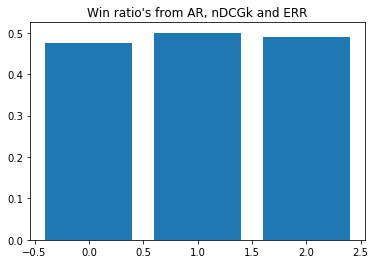

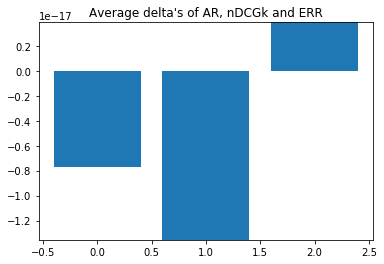

#### Online Evaluation ####
0.5017055252941937


In [31]:
import numpy as np
import scipy.stats as stats

# Obtain ranked pairs from algorithm P and E
grades = ['HR', 'R', 'N']
rank_len = 5
ranked_pairs = list(generate_ranking_pairs(grades, rank_len))

##### Offline #####
# Perform offline evaluation experiments using the three different
# evaluation metrics: average precision, nDCGk and ERR
delta_AP, delta_nDCGk, delta_ERR = [], [], []
for P, E in ranked_pairs:
    delta_AP.append(delta_measure(P,E,'average precision'))
    delta_nDCGk.append(delta_measure(P,E,'nDCGk'))
    delta_ERR.append(delta_measure(P,E,'ERR'))

# Compute win ratio's per evaluation metric
# delta_AP = np.array([x for x in delta_AP if x > 0])
# delta_nDCGk = np.array([x for x in delta_nDCGk if x > 0])
# delta_ERR = np.array([x for x in delta_ERR if x > 0])
# n = len(ranked_pairs)
# win_ratio_AP = len(delta_AP)/n
# win_ratio_nDCGk = len(delta_nDCGk)/n
# win_ratio_ERR = len(delta_ERR)/n

# Perform statistical tests on offline evaluations
# The Null Hypothesis is that P and E perform the same:
# their test statistic values are identically distributed.
# Three different test statistics will be used (AP, nDCGk and ERR).

t_AP = np.mean(delta_AP)/(np.std(delta_AP)/len(delta_AP))
p_AP = 1 - stats.norm(0,1).cdf(t_AP)
print(p_AP)


# Plot win ratio's and average deltas
print('#'*4, 'Offline Evaluation', '#'*4)
plt.bar([0,1,2],[win_ratio_AP, win_ratio_ERR, win_ratio_nDCGk])
plt.title('Win ratio\'s from AR, nDCGk and ERR')
plt.show()

plt.bar([0,1,2],[np.mean(delta_AP), np.mean(delta_nDCGk), np.mean(delta_ERR)])
plt.title('Average delta\'s of AR, nDCGk and ERR')
plt.show()


##### Online #####
# Run online experiments using team draft interleaving and 
# three different click models.  
N = 10
click_log_path = 'YandexRelPredChallenge.txt'
click_model = RandomClickModel(click_log_path)

# Compute win ratio of algorithm E (1) over P (0)
win_ratio = simulate_experiment(ranked_pairs, N, click_model)

print('#'*4, 'Online Evaluation', '#'*4)

print(win_ratio)